In [664]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score

## Data description

* **loanId** :	unique	loan	identifier.
* **anon_ssn**: This is a hash based on a client’s ssn. if it is an	ssn	to compare if a loan belongs to a previous customer.
* **payFrequency**: repayment	frequency	of	the	loan.
* **apr**: the	loan	apr	%
* **applicationDate**: Date	of	application	(start	date)
* **originated**: Whether or not a loan has been originated (first step of underwriting	before loan is funded)
* **originatedDate**: Date of origination day the loan was originated
* **nPaidOff**: How	many loans this client has paid off in the past
* **approved**: Whether or not a loan has been approved (final step of underwriting	before a loan deposit is attempted)
* **isFunded**: Whether	or not a loan is ultimately	funded.	–a loan can be voided by a customer shortly	after it is	approved, so not all approved loans	are ultimately funded
* **loanStatus**: Current 	loan	status.	Most	are	self explanatory.	Below	are	the	statuses	which	need **clarification**: application status (**Returned	Item**: missed 1 payment (but	not	more), due to insufficient funds, **Rejected**: Rejected by automated underwriting rules not by human underwriters, **Withdrawn Application** application abandoned for more than 2 weeks, or is withdrawn	by a human underwriter or customer, Statuses with the word “void” in them mean a loan that is approved but cancelled. (One	reason	is	the	loan failed to be debited into the customer’s account).
* **loanAmount**: Principal	of loan for	non-funded loans this will be the principal	in the loan application
* **originallyScheduledPaymentAmount**: This	is	the	originally	scheduled	repayment	amount	(if	a	customer	pays	off	all	his scheduled	payments,	this	is	the amount	we	should	receive)
* **state**: Client’s	state
* **Lead type**: The lead type determines the underwriting rules for a lead.
**bvMandatory**:	leads that are bought from the ping	tree required to perform bank verification before loan approval.
**lead**:	very similar	to bvMandatory, except bank verification is optional for loan	approval
**california**:	similar	to	(ii),	but	optimized	for	California	lending	rules
**organic**:	customers	that	came	through	the	MoneyLion	website
**rc_returning**:	customers	who	have	at	least	1	paid	off	loan	in	another	loan portfolio.	(The	first	paid	off	loan	is	not	in	this	data	set).
**prescreen**:	preselected	customers	who	have	been	offered	a	loan	through direct	mail	campaigns
**express**:	promotional	“express”	loans
**repeat**:	promotional	loans	offered	through	sms
**instant-offer**:	promotional	“instant-offer”	loans
* **Lead cost**: Cost of the lead
* **fpStatus**: Result	of	the	first	payment	of	the	loan:
**i. Checked**	–	payment	is	successful
**ii. Rejected**	–	payment	is	unsuccessful
**iii. Cancelled**	–	payment	is	cancelled
**iv. No Payments/No Schedule**	–	loan	is	not	funded
**v. Pending**	–	ACH	attempt	has	been	submitted	to	clearing	house	but	no response	yet
**vi. Skipped**	–	payment	has	been	skipped
**vii. None**	–	No	ACH	attempt	has	been	made	yet	–	usually	because	the	payment	is scheduled	for	the	future
* **clarityFraudId**: unique underwriting id. Can be used to join with columns in the clarity_underwriting_variables.csv	file

In [665]:
loan=pd.read_csv("loan.csv")

In [666]:
 loan

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577677,LL-I-12122269,801262d04720d32040612759857f4147,B,590.0,2016-11-08T17:32:33.554000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1292.41,NV,bvMandatory,3,NaN,58220cdde4b051c58d919c1f,1
577678,LL-I-16183462,e37750de9d99a67e0fa96a51e86fdf5b,S,490.0,2017-01-24T22:20:59.818000,False,NaN,0.0,False,0,Withdrawn Application,1000.0,2592.39,MO,lead,25,NaN,5887d349e4b08f249ac45e2f,1
577679,LL-I-06962710,d7e55e85266208ac4c353f42ebcde5ca,B,590.0,2016-02-02T03:05:47.797000,False,NaN,0.0,False,0,Withdrawn Application,300.0,844.75,IN,bvMandatory,6,NaN,550b1f59e4b0d4592e28c84e,1
577680,LL-I-01253468,c3b35307cb36116bf59574f9138d3dad,B,550.0,2015-05-21T20:19:49.639000,False,NaN,0.0,False,0,Withdrawn Application,300.0,770.80,OH,organic,6,NaN,NaN,0


1. This is the sample of the dataset where 577682 rows and 19 columns are avalable

## Data description

* **loanId**: This	is	a	unique	loan	identifier.	Use	this	for	joins	with	the	loan.csv	file
* **isCollection**: A	loan	can	have	a	custom	made	collection	plan	if	the	customer	has	trouble	making repayments	as	per	the	original	schedule.	TRUE means	the	payment	is	from	a	custom made	collection	plan.
* **installmentIndex**: a. This	counts	the	nth	payment	for	the	loan.	First	payment	is	1,	2 payment	is	2	and	so on. nd
b. This	index	resets	for	collection	payment	plans.	So	some	loans	can	have	2	payments with	the	same	installmentIndex.	One	from	the	regular	plan	and	one	from	the collection	plan.
* **paymentdate**:
a. Effective	of	payment
* **prinicpal**: principal	component	of	the	payment
* **fees**: Fee interest	amount	of	the	payment
* **paymentAmount**: Total	amount	of	the	payment, Usually	equals	to	fees	+	principal
* **paymentStatus**:
**a. Checked**	–	payment	is	successful
**b. Rejected**	–	payment	is	unsuccessful
**c. Cancelled**	–	payment	is	cancelled
**d. Pending**	–	ACH	attempt	has	been	submitted	to	clearing	house	but	no	response	yet
**e. Skipped**	–	payment	has	been	skipped
**f. None**	–	No	ACH	attempt	has	been	made	yet	–	usually	because	the	payment	is scheduled	for	the	future
**g. Rejected awaiting retry**	–	retrying	a	failed	ACH	attempt.
* **paymentReturnCode**:	these	are	ACH	error	codes	to	explain	why	the	payment	failed.	You	can	find	more	information	about	this	at	the	end	of	this	document,	or	visit	the	following	**link**: https://www.vericheck.com/ach-return-codes/

In [667]:
payment=pd.read_csv("payment.csv")

In [668]:
payment

,Unnamed: 0,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,isFunded
0,0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577677,577677,LL-I-12122269,801262d04720d32040612759857f4147,B,590.0,2016-11-08T17:32:33.554000,False,NaN,0.0,False,Withdrawn Application,400.0,1292.41,NV,bvMandatory,3,NaN,58220cdde4b051c58d919c1f,1
577678,577678,LL-I-16183462,e37750de9d99a67e0fa96a51e86fdf5b,S,490.0,2017-01-24T22:20:59.818000,False,NaN,0.0,False,Withdrawn Application,1000.0,2592.39,MO,lead,25,NaN,5887d349e4b08f249ac45e2f,1
577679,577679,LL-I-06962710,d7e55e85266208ac4c353f42ebcde5ca,B,590.0,2016-02-02T03:05:47.797000,False,NaN,0.0,False,Withdrawn Application,300.0,844.75,IN,bvMandatory,6,NaN,550b1f59e4b0d4592e28c84e,1
577680,577680,LL-I-01253468,c3b35307cb36116bf59574f9138d3dad,B,550.0,2015-05-21T20:19:49.639000,False,NaN,0.0,False,Withdrawn Application,300.0,770.80,OH,organic,6,NaN,NaN,0


In [669]:
payment

,Unnamed: 0,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,isFunded
0,0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577677,577677,LL-I-12122269,801262d04720d32040612759857f4147,B,590.0,2016-11-08T17:32:33.554000,False,NaN,0.0,False,Withdrawn Application,400.0,1292.41,NV,bvMandatory,3,NaN,58220cdde4b051c58d919c1f,1
577678,577678,LL-I-16183462,e37750de9d99a67e0fa96a51e86fdf5b,S,490.0,2017-01-24T22:20:59.818000,False,NaN,0.0,False,Withdrawn Application,1000.0,2592.39,MO,lead,25,NaN,5887d349e4b08f249ac45e2f,1
577679,577679,LL-I-06962710,d7e55e85266208ac4c353f42ebcde5ca,B,590.0,2016-02-02T03:05:47.797000,False,NaN,0.0,False,Withdrawn Application,300.0,844.75,IN,bvMandatory,6,NaN,550b1f59e4b0d4592e28c84e,1
577680,577680,LL-I-01253468,c3b35307cb36116bf59574f9138d3dad,B,550.0,2015-05-21T20:19:49.639000,False,NaN,0.0,False,Withdrawn Application,300.0,770.80,OH,organic,6,NaN,NaN,0


This is the sample of payment dataset where 689364 rows and 9 columns are avalable. 


## Data description

Printing sample data where 49752 rows and 54 columns are avaliable.

In [670]:
loan.shape

(577682, 19)

Printing shape data
**Rows**: 577682
**columns**: 19


In [671]:
loan.columns

Index(['loanId', 'anon_ssn', 'payFrequency', 'apr', 'applicationDate',
       'originated', 'originatedDate', 'nPaidOff', 'approved', 'isFunded',
       'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount', 'state',
       'leadType', 'leadCost', 'fpStatus', 'clarityFraudId', 'hasCF'],
      dtype='object')

The name of the columns

In [672]:
loan.isna().sum()

loanId                                 256
anon_ssn                                 0
payFrequency                          1273
apr                                   3922
applicationDate                          0
originated                               0
originatedDate                      531638
nPaidOff                                24
approved                                 0
isFunded                                 0
loanStatus                             391
loanAmount                            2250
originallyScheduledPaymentAmount         0
state                                  132
leadType                                 0
leadCost                                 0
fpStatus                            525959
clarityFraudId                      219989
hasCF                                    0
dtype: int64

1. numbers of null values in the data set
2. we can observe that "**fpStatus**" column most of the data are missing, the column **clarityFraudId** 219989 number of rows data are missing. so I will saperate the tow column and I will analysis saperately.
3. **originatedDate** this column data are missing most of the data. I will drop the column.
4. Othere missing data rows i will drop because in the the dataset have large numner of rows with compare to missing rows for analysis.

In [673]:
loan[loan.duplicated()==True]

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF


No duplicate values are available

In [674]:
loan.describe()

,apr,nPaidOff,isFunded,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF
count,573760.000000,577658.000000,577682.000000,575432.000000,577682.000000,577682.000000,577682.000000
mean,553.080972,0.037887,0.067480,514.245084,1428.897209,7.854389,0.619187
std,110.046159,0.333366,0.250852,320.939929,925.009141,12.853451,0.485587
min,0.000000,0.000000,0.000000,0.000000,-816.710000,0.000000,0.000000
25%,490.000000,0.000000,0.000000,350.000000,1023.640000,3.000000,0.000000
50%,590.000000,0.000000,0.000000,500.000000,1245.250000,3.000000,1.000000
75%,601.000000,0.000000,0.000000,500.000000,1615.660000,6.000000,1.000000
max,705.590000,21.000000,1.000000,5000.000000,19963.630000,200.000000,1.000000


In the data 25 parcentile of datapoints apr is 490 and 75 parcentile of datapoints apr is 601 so 0 apr may be outlayer
loanAmount min are 0 those datapoints are outlayer
    

In [675]:
loan.dtypes

loanId                               object
anon_ssn                             object
payFrequency                         object
apr                                 float64
applicationDate                      object
originated                             bool
originatedDate                       object
nPaidOff                            float64
approved                               bool
isFunded                              int64
loanStatus                           object
loanAmount                          float64
originallyScheduledPaymentAmount    float64
state                                object
leadType                             object
leadCost                              int64
fpStatus                             object
clarityFraudId                       object
hasCF                                 int64
dtype: object

 In the dataset we can see the data type and plan to saperate the data, numerical data and catagorical data.

In [676]:
loan[loan["loanAmount"]==0].index

Index([  2914,   4043,   4507,   7027,   8287,  14577,  16178,  16950,  17795,
        20373,
       ...
       560635, 560866, 560874, 564333, 564590, 564969, 566404, 568240, 571420,
       574259],
      dtype='int64', length=417)

In the dataset **loanAmount** should not be 0. Those rows are outlyer.
we can drop the rows.

In [677]:
loan.shape

(577682, 19)

Before removeing the rows, number of rows avalable in the dataset is 577682

#### outlyer removeing

In [678]:
for i in loan[loan["loanAmount"]==0].index:
    loan.drop(i,axis=0,inplace=True)

Removing the missing value rows of the column **loanAmount**

In [679]:
loan.shape # after removing the row loan dataset updated rows.

(577265, 19)

In [680]:
loan.drop("originatedDate",axis=1,inplace=True) ## drop the column originatedDate

The column **applicationDate** the year and month saperate from the column and create a new columns for year and month to analysis month with year people are more active and drop the column form the dataset.

In [681]:
loan["Application_Year"]=loan["applicationDate"].str.split("-").str[0]   

In [682]:
loan["Application_Month"]=loan["applicationDate"].str.split("-").str[1]

In [683]:
loan.drop("applicationDate",axis=1,inplace=True)

In [684]:
loan.dropna(subset=["loanStatus"], axis=0, inplace=True)

In [685]:
loan.dropna(subset=["loanAmount"], axis=0, inplace=True)

In [686]:
loan.dropna(subset=["payFrequency","apr"], axis=0, inplace=True)

In [687]:
loan.dropna(subset=["nPaidOff"], axis=0, inplace=True)

In [688]:
loan.dropna(subset=["state"], axis=0, inplace=True)

In [689]:
loan.drop(["fpStatus","clarityFraudId"],axis=1,inplace=True)

**loanStatus, loanAmount, payFrequency, nPaidOff, state, fpStatus, clarityFraudId** has been drop na valuses rows because few null values with respect to the dataset total rows which will not so much impact on the full dataset.

In [690]:
loan.isna().sum()

loanId                              0
anon_ssn                            0
payFrequency                        0
apr                                 0
originated                          0
nPaidOff                            0
approved                            0
isFunded                            0
loanStatus                          0
loanAmount                          0
originallyScheduledPaymentAmount    0
state                               0
leadType                            0
leadCost                            0
hasCF                               0
Application_Year                    0
Application_Month                   0
dtype: int64

In the datast no null values

In [691]:
catogorical_column=loan.columns[loan.dtypes=="object"]

The catogorical_columns name has been saperated.

In [692]:
catogorical_column  # catogorical column name 

Index(['loanId', 'anon_ssn', 'payFrequency', 'loanStatus', 'state', 'leadType',
       'Application_Year', 'Application_Month'],
      dtype='object')

In [693]:
numerical_column=loan.columns[loan.dtypes!="object"]  # numerical column name

In [694]:
# Step 1: Get the value counts of 'anon_ssn'
ssn_counts = loan["anon_ssn"].value_counts()

# Step 2: Filter for 'anon_ssn' values that occur more than once
ssn_more_than_once = ssn_counts[ssn_counts > 1].index

# Step 3: Filter the original DataFrame for these 'anon_ssn' values
result = loan[loan["anon_ssn"].isin(ssn_more_than_once)]

# If you only want the 'anon_ssn' column
anon_ssn_result = result["anon_ssn"]


In [695]:
anon_ssn_result

3         9be6f443bb97db7e95fa0c281d34da91
4         63b5494f60b5c19c827c7b068443752c
5         b5541f49472fa0fce8e473306768f7fb
7         02596517e7633c7e87e6b333a0fb1bbe
9         47bf79119075e41ef65510f2900c8e4a
                        ...               
577666    ad6970cdb83f6f5fc0154ac8e2d6746a
577675    43ff47d188fa9350e43f18094254b4d1
577676    3506893b63baae416cf211238a391acc
577680    c3b35307cb36116bf59574f9138d3dad
577681    dc0a43b16c037ee5d0142daebb5db83a
Name: anon_ssn, Length: 195522, dtype: object

This is the result where 195522 individual clints whose loan belongs to a previous customer.

In [696]:
anon_ssn_result.shape

(195522,)

In [697]:
numerical_column

Index(['apr', 'originated', 'nPaidOff', 'approved', 'isFunded', 'loanAmount',
       'originallyScheduledPaymentAmount', 'leadCost', 'hasCF'],
      dtype='object')

In [698]:
loan[numerical_column]

,apr,originated,nPaidOff,approved,isFunded,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF
0,360.0,False,0.0,False,0,500.0,978.27,6,1
1,199.0,True,0.0,True,1,3000.0,6395.19,0,1
2,590.0,False,0.0,False,0,400.0,1199.45,3,1
3,360.0,False,0.0,False,0,500.0,1074.05,3,1
4,590.0,False,0.0,False,0,350.0,814.37,3,1
...,...,...,...,...,...,...,...,...,...
577677,590.0,False,0.0,False,0,400.0,1292.41,3,1
577678,490.0,False,0.0,False,0,1000.0,2592.39,25,1
577679,590.0,False,0.0,False,0,300.0,844.75,6,1
577680,550.0,False,0.0,False,0,300.0,770.80,6,0


In [699]:
loan[catogorical_column]

,loanId,anon_ssn,payFrequency,loanStatus,state,leadType,Application_Year,Application_Month
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,Withdrawn Application,IL,bvMandatory,2016,02
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,Paid Off Loan,CA,prescreen,2016,01
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,Withdrawn Application,MO,bvMandatory,2016,08
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,Withdrawn Application,IL,bvMandatory,2015,08
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,Rejected,NV,bvMandatory,2016,06
...,...,...,...,...,...,...,...,...
577677,LL-I-12122269,801262d04720d32040612759857f4147,B,Withdrawn Application,NV,bvMandatory,2016,11
577678,LL-I-16183462,e37750de9d99a67e0fa96a51e86fdf5b,S,Withdrawn Application,MO,lead,2017,01
577679,LL-I-06962710,d7e55e85266208ac4c353f42ebcde5ca,B,Withdrawn Application,IN,bvMandatory,2016,02
577680,LL-I-01253468,c3b35307cb36116bf59574f9138d3dad,B,Withdrawn Application,OH,organic,2015,05


In [700]:
a=loan['state'].unique()

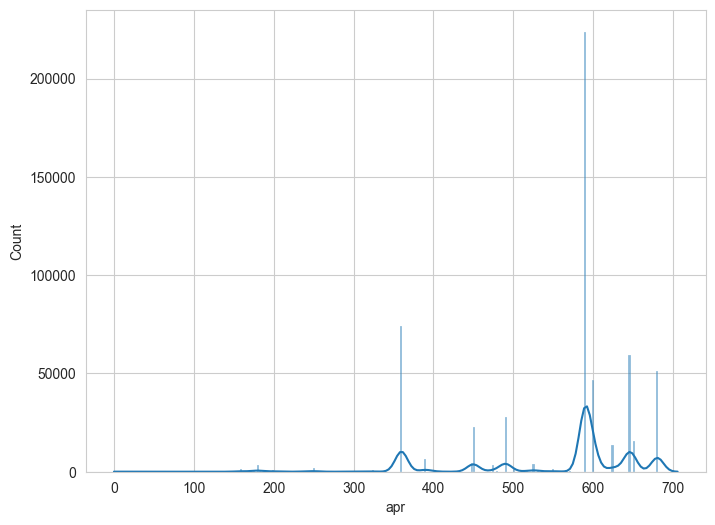

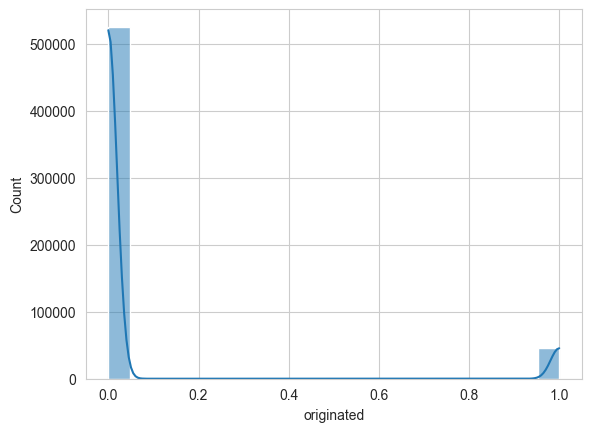

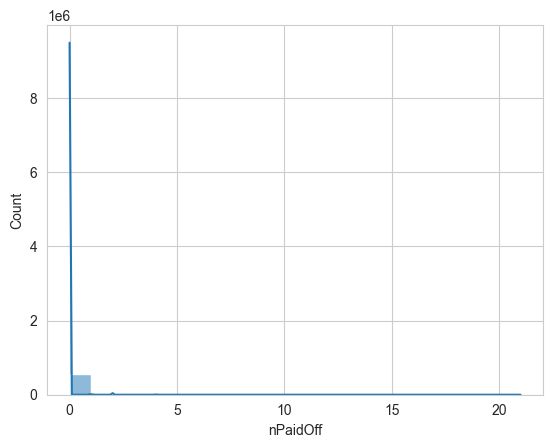

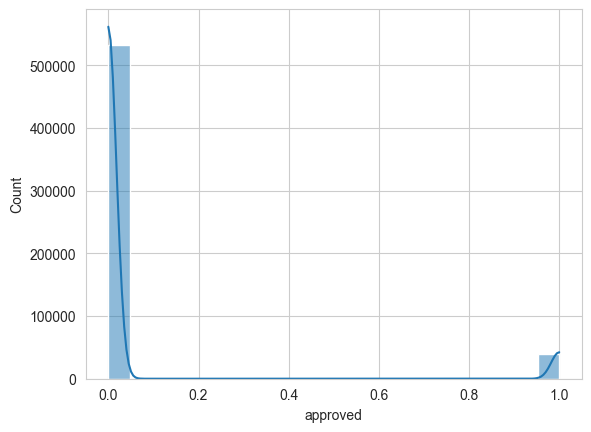

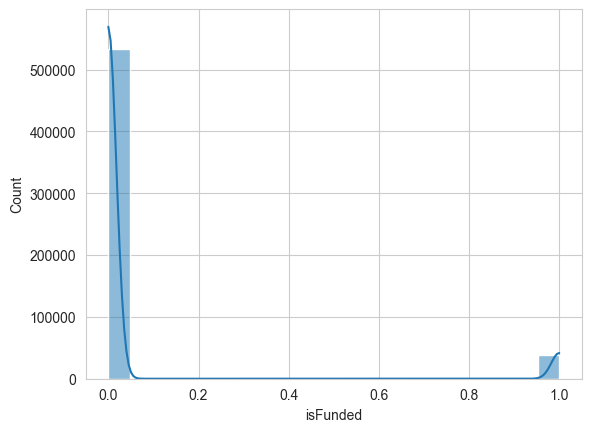

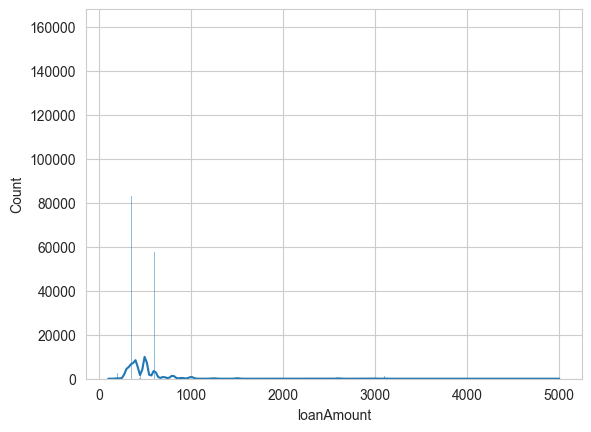

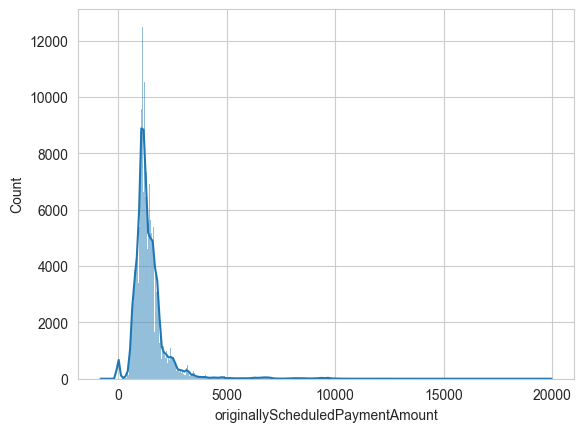

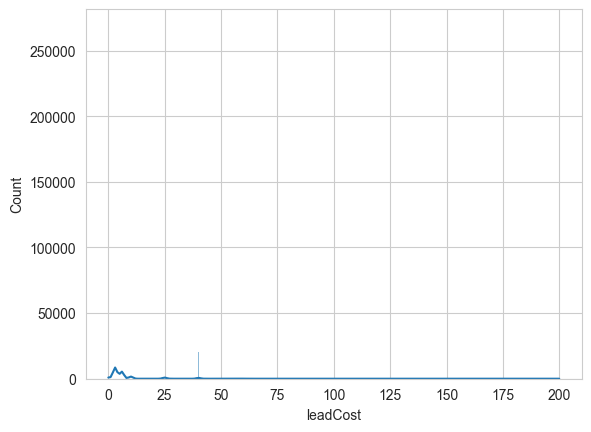

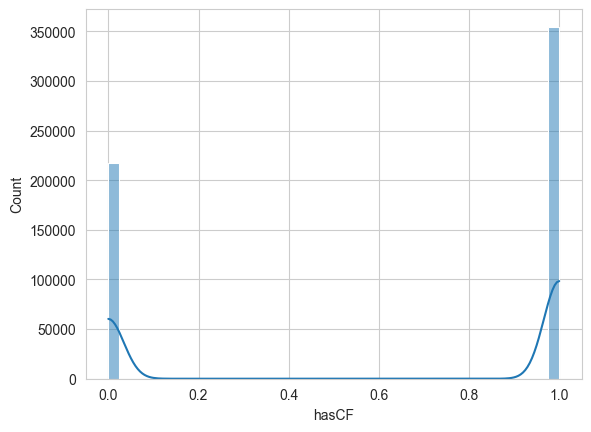

In [701]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
x=0
for i in numerical_column:
    sns.histplot(data=loan,x=i,kde=True)
    print('\n')
    plt.show()

In [702]:
loan.groupby(by=['state'])['loanAmount'].mean()

state
AK          512.804878
AL          438.151796
AZ          524.643585
CA          922.706079
CO          494.058856
CT          537.488356
DE          467.796128
FL          472.037134
GA         3237.669383
HI          503.282010
IA          498.786127
ID          451.588072
IL          480.973797
IN          486.710881
KS          472.892799
KY          478.496366
LA          451.356475
MD          529.000000
MI          473.040589
MN          549.569841
MO          464.498264
MS          439.160700
NC          678.105561
ND          504.756098
NE          505.717666
NJ          559.076691
NM          445.658915
NV          496.444299
NY         1304.000000
OH          463.834854
OH-TEST     500.000000
OK          465.687393
PA          532.993082
RI          480.685131
SC          638.610974
SD          485.899818
TN          449.952398
TX          433.566002
TX-TEST     500.000000
UT          476.852591
VA          634.820759
WA          551.123278
WI          448.076350
WY   

The state is GA and NY, Person loan amount quite high person. More possibility is the state is rich state. 
So the state may property price may high. 
May people leaving cost high,
May possable the state is developed state,
Possibility the state is finincial hub on the country.

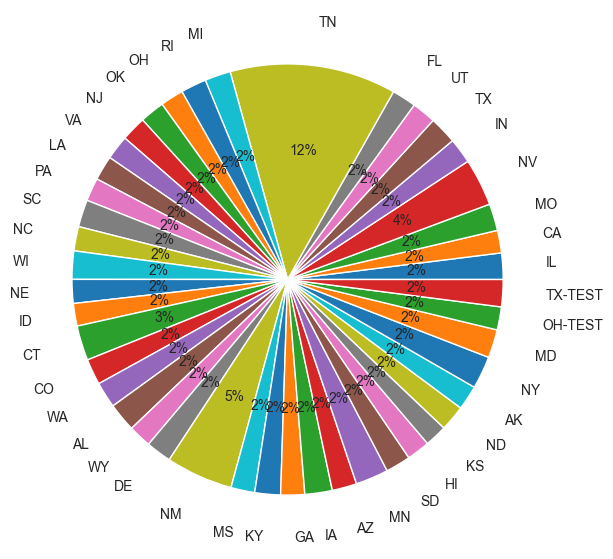

In [703]:
plt.figure(figsize=(7,7))
plt.pie(x = loan.groupby(by=['state'])['loanAmount'].mean(),labels=list(a),autopct='%1.0f%%', labeldistance=1.2)
plt.show()

In [704]:
loan

,loanId,anon_ssn,payFrequency,apr,originated,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,hasCF,Application_Year,Application_Month
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,False,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,1,2016,02
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,True,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,1,2016,01
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,False,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,1,2016,08
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,False,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,1,2015,08
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,False,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,1,2016,06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577677,LL-I-12122269,801262d04720d32040612759857f4147,B,590.0,False,0.0,False,0,Withdrawn Application,400.0,1292.41,NV,bvMandatory,3,1,2016,11
577678,LL-I-16183462,e37750de9d99a67e0fa96a51e86fdf5b,S,490.0,False,0.0,False,0,Withdrawn Application,1000.0,2592.39,MO,lead,25,1,2017,01
577679,LL-I-06962710,d7e55e85266208ac4c353f42ebcde5ca,B,590.0,False,0.0,False,0,Withdrawn Application,300.0,844.75,IN,bvMandatory,6,1,2016,02
577680,LL-I-01253468,c3b35307cb36116bf59574f9138d3dad,B,550.0,False,0.0,False,0,Withdrawn Application,300.0,770.80,OH,organic,6,0,2015,05


In [705]:
loan.dtypes

loanId                               object
anon_ssn                             object
payFrequency                         object
apr                                 float64
originated                             bool
nPaidOff                            float64
approved                               bool
isFunded                              int64
loanStatus                           object
loanAmount                          float64
originallyScheduledPaymentAmount    float64
state                                object
leadType                             object
leadCost                              int64
hasCF                                 int64
Application_Year                     object
Application_Month                    object
dtype: object

In [706]:
loan[loan.isna()==True].columns

Index(['loanId', 'anon_ssn', 'payFrequency', 'apr', 'originated', 'nPaidOff',
       'approved', 'isFunded', 'loanStatus', 'loanAmount',
       'originallyScheduledPaymentAmount', 'state', 'leadType', 'leadCost',
       'hasCF', 'Application_Year', 'Application_Month'],
      dtype='object')

In [707]:
loan["payFrequency"].value_counts()

payFrequency
B    313900
W    136288
M     58501
I     33687
S     29491
Name: count, dtype: int64

1. we can say that biweekly payments coustome is more which is 55 parcentile, so people are more prefer the biweekly payments. If people more like biweekly then it is more covinent to add addin option which upsealing. 

2. the option **semi monthly** is less all of them. so the we can make it more atractive using offers.

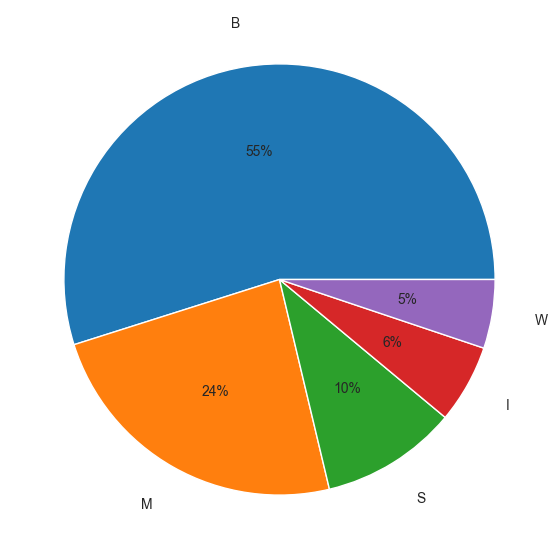

In [708]:
plt.figure(figsize=(7,7))
plt.pie(x = loan["payFrequency"].value_counts(),labels=list(loan["payFrequency"].unique()),autopct='%1.0f%%', labeldistance=1.2)
plt.show()

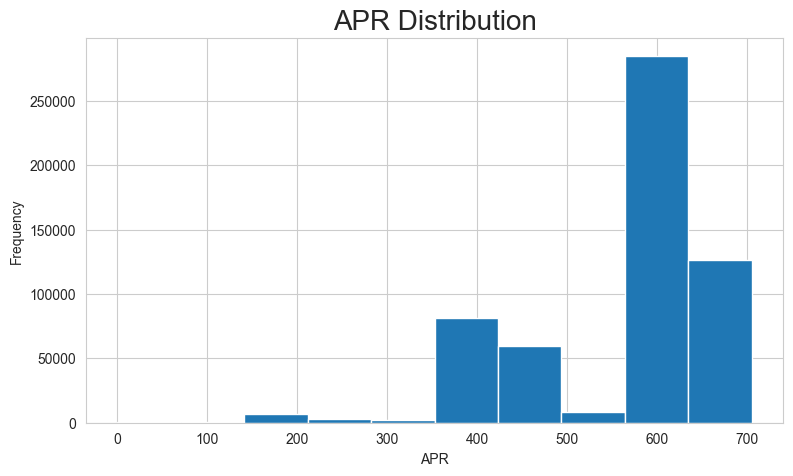

In [709]:
plt.figure(figsize=(9,5))
plt.hist(x = 'apr',data=loan)
plt.title('APR Distribution',size = 20)
plt.xlabel('APR')
plt.ylabel('Frequency')
plt.show()

we can say from the apr distribution data, 600 value is more popular compare to other options

In [710]:
loan["loanStatus"].unique()

array(['Withdrawn Application', 'Paid Off Loan', 'Rejected', 'New Loan',
       'Internal Collection', 'CSR Voided New Loan',
       'External Collection', 'Returned Item', 'Customer Voided New Loan',
       'Credit Return Void', 'Pending Paid Off', 'Charged Off Paid Off',
       'Settled Bankruptcy', 'Settlement Paid Off', 'Charged Off',
       'Pending Rescind', 'Customver Voided New Loan',
       'Pending Application', 'Voided New Loan',
       'Pending Application Fee', 'Settlement Pending Paid Off'],
      dtype=object)

In [711]:
crosstabdata=pd.crosstab(index = loan['approved'], columns = loan['state'],margins=True)
crosstabdata

state,AK,AL,AZ,CA,CO,CT,DE,FL,GA,HI,...,SD,TN,TX,TX-TEST,UT,VA,WA,WI,WY,All
approved,,,,,,,,,,,,,,,,,,,,,
False,254,4059,2715,20745,3138,1099,801,23968,1573,565,...,2107,31409,46384,1,6511,7781,1130,37454,1627,531852
True,33,256,621,1676,464,361,77,1844,145,52,...,89,1352,3164,0,205,1391,249,2641,81,40015
All,287,4315,3336,22421,3602,1460,878,25812,1718,617,...,2196,32761,49548,1,6716,9172,1379,40095,1708,571867


we can compare the value of chancess of approve with respect to the state.

In [712]:
crosstabdata.index

Index([False, True, 'All'], dtype='object', name='approved')

In [713]:
loan["leadType"].value_counts()

leadType
bvMandatory      472031
lead              71445
organic           21365
prescreen          4420
rc_returning       2040
california          479
repeat               24
express              22
instant-offer        21
lionpay              20
Name: count, dtype: int64

from the dataset **bvMandatory** is more leadType compayer to others 

In [714]:
loan["state"].value_counts()

state
OH         88240
IL         66205
TX         49548
MO         48955
WI         40095
MI         34387
TN         32761
NC         26724
FL         25812
IN         25550
SC         23420
CA         22421
NV         11427
PA          9685
VA          9172
NJ          7615
UT          6716
AL          4315
MS          3771
CO          3602
LA          3421
AZ          3336
NM          3225
KY          2889
SD          2196
MN          2069
OK          1753
GA          1718
WY          1708
CT          1460
WA          1379
KS          1222
IA          1038
DE           878
ID           721
RI           686
NE           634
HI           617
AK           287
ND           205
NY             1
MD             1
OH-TEST        1
TX-TEST        1
Name: count, dtype: int64

In [715]:
loan

,loanId,anon_ssn,payFrequency,apr,originated,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,hasCF,Application_Year,Application_Month
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,False,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,1,2016,02
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,True,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,1,2016,01
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,False,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,1,2016,08
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,False,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,1,2015,08
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,False,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,1,2016,06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577677,LL-I-12122269,801262d04720d32040612759857f4147,B,590.0,False,0.0,False,0,Withdrawn Application,400.0,1292.41,NV,bvMandatory,3,1,2016,11
577678,LL-I-16183462,e37750de9d99a67e0fa96a51e86fdf5b,S,490.0,False,0.0,False,0,Withdrawn Application,1000.0,2592.39,MO,lead,25,1,2017,01
577679,LL-I-06962710,d7e55e85266208ac4c353f42ebcde5ca,B,590.0,False,0.0,False,0,Withdrawn Application,300.0,844.75,IN,bvMandatory,6,1,2016,02
577680,LL-I-01253468,c3b35307cb36116bf59574f9138d3dad,B,550.0,False,0.0,False,0,Withdrawn Application,300.0,770.80,OH,organic,6,0,2015,05


In [716]:
loan.dtypes

loanId                               object
anon_ssn                             object
payFrequency                         object
apr                                 float64
originated                             bool
nPaidOff                            float64
approved                               bool
isFunded                              int64
loanStatus                           object
loanAmount                          float64
originallyScheduledPaymentAmount    float64
state                                object
leadType                             object
leadCost                              int64
hasCF                                 int64
Application_Year                     object
Application_Month                    object
dtype: object

In [717]:
loan.value_counts("originated")

originated
False    525882
True      45985
Name: count, dtype: int64

In [718]:
vc=variables.columns

In [719]:
vc

Index(['thirtydaysago', 'twentyfourhoursago', 'oneminuteago', 'onehourago',
       'ninetydaysago', 'sevendaysago', 'tenminutesago', 'fifteendaysago',
       'threesixtyfivedaysago', 'inquiryonfilecurrentaddressconflict',
       'totalnumberoffraudindicators',
       'telephonenumberinconsistentwithaddress',
       'inquiryageyoungerthanssnissuedate', 'onfileaddresscautious',
       'inquiryaddressnonresidential', 'onfileaddresshighrisk',
       'ssnreportedmorefrequentlyforanother',
       'currentaddressreportedbytradeopenlt90days', 'inputssninvalid',
       'inputssnissuedatecannotbeverified', 'inquiryaddresscautious',
       'morethan3inquiriesinthelast30days', 'onfileaddressnonresidential',
       'creditestablishedpriortossnissuedate', 'driverlicenseformatinvalid',
       'inputssnrecordedasdeceased', 'inquiryaddresshighrisk',
       'inquirycurrentaddressnotonfile',
       'bestonfilessnissuedatecannotbeverified',
       'highprobabilityssnbelongstoanother',
       'maxnumberofs

In [720]:
variables.columns=variables.columns.str.split(".").str[-1]

In [721]:
variables

,thirtydaysago,twentyfourhoursago,oneminuteago,onehourago,ninetydaysago,sevendaysago,tenminutesago,fifteendaysago,threesixtyfivedaysago,inquiryonfilecurrentaddressconflict,...,phonematchtypedescription,overallmatchresult,phonetype,ssndobreasoncode,ssnnamereasoncode,nameaddressreasoncode,ssndobmatch,overallmatchreasoncode,clearfraudscore,underwritingid
0,8.0,2.0,2.0,2.0,8.0,2.0,2.0,5.0,10.0,False,...,(M) Mobile Phone,partial,NaN,NaN,NaN,A8,match,6.0,871.0,54cbffcee4b0ba763e43144d
1,5.0,2.0,2.0,2.0,11.0,2.0,2.0,4.0,21.0,True,...,(M) Mobile Phone,partial,NaN,NaN,NaN,NaN,match,11.0,397.0,54cc0408e4b0418d9a7f78af
2,9.0,4.0,2.0,3.0,10.0,8.0,2.0,9.0,25.0,False,...,(M) Mobile Phone,match,NaN,NaN,NaN,NaN,match,1.0,572.0,54cc0683e4b0418d9a80adb6
3,3.0,2.0,2.0,2.0,9.0,2.0,2.0,2.0,9.0,False,...,(M) Mobile Phone,partial,NaN,NaN,NaN,NaN,match,11.0,838.0,54cc0780e4b0ba763e43b74a
4,5.0,5.0,2.0,2.0,6.0,5.0,2.0,5.0,6.0,False,...,(M) Mobile Phone,match,NaN,NaN,NaN,NaN,match,1.0,768.0,54cc1d67e4b0ba763e445b45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49747,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,24.0,False,...,(M) Mobile Phone,partial,NaN,NaN,NaN,NaN,match,11.0,677.0,58cc5706e4b0b0437e26b19c
49748,6.0,4.0,1.0,4.0,11.0,4.0,1.0,4.0,17.0,False,...,(M) Mobile Phone,partial,NaN,NaN,NaN,NaN,match,16.0,640.0,58cc5763e4b0b0437e272d38
49749,4.0,4.0,1.0,4.0,4.0,4.0,1.0,4.0,5.0,False,...,(M) Mobile Phone,match,NaN,NaN,NaN,NaN,match,1.0,576.0,58cc57d4e4b0b0437e278bff
49750,3.0,3.0,2.0,2.0,3.0,3.0,2.0,3.0,25.0,False,...,(M) Mobile Phone,match,NaN,NaN,NaN,NaN,match,1.0,830.0,58cc5916e4b0b0437e2b6e07


In [722]:
result=pd.merge(loan, payment, how="outer", on="loanId")

In [723]:
result

,loanId,anon_ssn_x,payFrequency_x,apr_x,originated_x,nPaidOff_x,approved_x,isFunded_x,loanStatus_x,loanAmount_x,...,approved_y,loanStatus_y,loanAmount_y,originallyScheduledPaymentAmount_y,state_y,leadType_y,leadCost_y,fpStatus,clarityFraudId,isFunded_y
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,False,0.0,False,0.0,Withdrawn Application,500.0,...,False,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,True,0.0,True,1.0,Paid Off Loan,3000.0,...,True,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,False,0.0,False,0.0,Withdrawn Application,400.0,...,False,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,False,0.0,False,0.0,Withdrawn Application,500.0,...,False,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,False,0.0,False,0.0,Rejected,350.0,...,False,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577677,LL-I-05955040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,Withdrawn Application,NaN,0.00,OH,bvMandatory,6,No Schedule,563c19fce4b07887b4bd91cd,1
577678,LL-I-11972743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,Rejected,300.0,0.00,CA,organic,0,No Payments,57d81a02e4b084ddd1b12513,1
577679,LL-I-00185080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,Withdrawn Application,300.0,870.24,OH,bvMandatory,3,NaN,NaN,0
577680,LL-I-00180260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,Withdrawn Application,300.0,815.98,OH,bvMandatory,3,NaN,NaN,0


In [724]:
payment.isna().sum()

Unnamed: 0                               0
loanId                                 256
anon_ssn                                 0
payFrequency                          1273
apr                                   3922
applicationDate                          0
originated                               0
originatedDate                      531638
nPaidOff                                24
approved                                 0
loanStatus                             391
loanAmount                            2250
originallyScheduledPaymentAmount         0
state                                  132
leadType                                 0
leadCost                                 0
fpStatus                            525959
clarityFraudId                      219989
isFunded                                 0
dtype: int64

In [725]:
loan.isna().sum()

loanId                              0
anon_ssn                            0
payFrequency                        0
apr                                 0
originated                          0
nPaidOff                            0
approved                            0
isFunded                            0
loanStatus                          0
loanAmount                          0
originallyScheduledPaymentAmount    0
state                               0
leadType                            0
leadCost                            0
hasCF                               0
Application_Year                    0
Application_Month                   0
dtype: int64

In [726]:
result.isna().sum()

loanId                                   256
anon_ssn_x                              5815
payFrequency_x                          5815
apr_x                                   5815
originated_x                            5815
nPaidOff_x                              5815
approved_x                              5815
isFunded_x                              5815
loanStatus_x                            5815
loanAmount_x                            5815
originallyScheduledPaymentAmount_x      5815
state_x                                 5815
leadType_x                              5815
leadCost_x                              5815
hasCF                                   5815
Application_Year                        5815
Application_Month                       5815
Unnamed: 0                                 0
anon_ssn_y                                 0
payFrequency_y                          1273
apr_y                                   3922
applicationDate                            0
originated

In [727]:
result.shape

(577682, 35)

In [728]:
result.columns

Index(['loanId', 'anon_ssn_x', 'payFrequency_x', 'apr_x', 'originated_x',
       'nPaidOff_x', 'approved_x', 'isFunded_x', 'loanStatus_x',
       'loanAmount_x', 'originallyScheduledPaymentAmount_x', 'state_x',
       'leadType_x', 'leadCost_x', 'hasCF', 'Application_Year',
       'Application_Month', 'Unnamed: 0', 'anon_ssn_y', 'payFrequency_y',
       'apr_y', 'applicationDate', 'originated_y', 'originatedDate',
       'nPaidOff_y', 'approved_y', 'loanStatus_y', 'loanAmount_y',
       'originallyScheduledPaymentAmount_y', 'state_y', 'leadType_y',
       'leadCost_y', 'fpStatus', 'clarityFraudId', 'isFunded_y'],
      dtype='object')

In [729]:
result.isna().sum()

loanId                                   256
anon_ssn_x                              5815
payFrequency_x                          5815
apr_x                                   5815
originated_x                            5815
nPaidOff_x                              5815
approved_x                              5815
isFunded_x                              5815
loanStatus_x                            5815
loanAmount_x                            5815
originallyScheduledPaymentAmount_x      5815
state_x                                 5815
leadType_x                              5815
leadCost_x                              5815
hasCF                                   5815
Application_Year                        5815
Application_Month                       5815
Unnamed: 0                                 0
anon_ssn_y                                 0
payFrequency_y                          1273
apr_y                                   3922
applicationDate                            0
originated

In [730]:
result.dropna(subset=list(result.columns[(result.isna().sum()>0)==True]), axis=0, inplace=True)

In [731]:
result.isna().sum()

loanId                                0
anon_ssn_x                            0
payFrequency_x                        0
apr_x                                 0
originated_x                          0
nPaidOff_x                            0
approved_x                            0
isFunded_x                            0
loanStatus_x                          0
loanAmount_x                          0
originallyScheduledPaymentAmount_x    0
state_x                               0
leadType_x                            0
leadCost_x                            0
hasCF                                 0
Application_Year                      0
Application_Month                     0
Unnamed: 0                            0
anon_ssn_y                            0
payFrequency_y                        0
apr_y                                 0
applicationDate                       0
originated_y                          0
originatedDate                        0
nPaidOff_y                            0


In [732]:
result.iloc[:,2:].dtypes

payFrequency_x                         object
apr_x                                 float64
originated_x                           object
nPaidOff_x                            float64
approved_x                             object
isFunded_x                            float64
loanStatus_x                           object
loanAmount_x                          float64
originallyScheduledPaymentAmount_x    float64
state_x                                object
leadType_x                             object
leadCost_x                            float64
hasCF                                 float64
Application_Year                       object
Application_Month                      object
Unnamed: 0                              int64
anon_ssn_y                             object
payFrequency_y                         object
apr_y                                 float64
applicationDate                        object
originated_y                             bool
originatedDate                    

In [733]:
result[["originated","approved","isCollection"]].dtypes

KeyError: "None of [Index(['originated', 'approved', 'isCollection'], dtype='object')] are in the [columns]"

In [ ]:
result[["originated","approved","isCollection"]].dtypes

In [ ]:
result[["originated","approved","isCollection"]].astype(int)

In [ ]:
payFrequency_map={"B":0,"W":1,"S":2,"M":3,"I":4}
loanStatus_map={"External Collection":0,
                "Paid Off Loan":1,
                "Internal Collection":2,
                "New Loan":3,
                "Settlement Paid Off":4,
                "Credit Return Void":5,
                "Customer Voided New Loan":6,
                "Settled Bankruptcy":7,
                "Returned Item":8,
                "Charged Off Paid Off":9,
                "Pending Paid Off":10,
                "CSR Voided New Loan":11,
                "Pending Rescind":12,
                "Withdrawn Application":13,
                "Voided New Loan":14,
                "Charged Off":15,
                "Settlement Pending Paid Off":16,
                "Customver Voided New Loan":17
                }
leadType_map={"bvMandatory":0,"lead":1,"organic":2,"prescreen":3,"rc_returning":4,"california":5,"repeat":6,"lionpay":7,"express":8,"rc_returning":9}
paymentStatus_map={"Cancelled":0,"Checked":1,"Rejected":2,"Pending":3,"Skipped":4,"Rejected Awaiting Retry":5,"Returned":6,"Complete":7}

result['payFrequency']=result['payFrequency'].map(payFrequency_map)
result['loanStatus']=result['loanStatus'].map(loanStatus_map)
result['leadType']=result['leadType'].map(leadType_map)
result['paymentStatus']=result['paymentStatus'].map(paymentStatus_map)

In [ ]:
state_map={"OH":0,"IL":1,"WI":2,"TX":3,"CA":4,"MI":5,"IN":6,"MO":7, "NC":8,"FL":9,"TN":10,"SC":11,
                   "PA":12,"NJ":13,"NV":14,"AZ":15,"VA":16,"CT":17,"MN":18,"KY":19,"AL":20,"LA":21,"WA":22,"MS":23,
                   "UT":24,"GA":25,"KS":26,"OK":27,"NM":28,"IA":29,"CO":30,"SD":31,"DE":32,"WY":33,"NE":34,"RI":35,
                   "ID":36,"HI":37,"AK":38,"ND":39,"MD":40}
result['state']=result['state'].map(state_map)

In [ ]:
result["state"].value_counts().index

In [ ]:
result1=result.copy()

In [ ]:
result.drop(["loanId","anon_ssn","paymentDate"], axis=1,inplace=True)

In [ ]:
array=result.iloc[:,2:].values

In [ ]:
array

In [ ]:
stscaler = StandardScaler().fit(array)
X = stscaler.transform(array)

In [ ]:
X

In [ ]:
result1

In [ ]:
result

In [ ]:
result.dtypes

In [ ]:
result[["Application_Year","Application_Month"]]=result[["Application_Year","Application_Month"]].astype(int)

In [ ]:
result["hasCF"].value_counts()

In [ ]:
result

In [ ]:
result.isna().sum()

In [ ]:
result2=result.copy()

In [ ]:
result

In [ ]:
# result=pd.read_csv("new_cl_result.csv")

In [ ]:
# result.drop("Unnamed: 0.1",axis=1,inplace=True)
# result.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
# result.drop("isFunded",axis=1,inplace=True)

In [ ]:
result

In [ ]:
# result=result[[s for s in result.columns if s!="hasCF"]+["hasCF"]]

In [ ]:
X = result.drop('sFunded',axis=1)
y = result[['sFunded']]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=123)

In [ ]:
X_train

In [ ]:
test=pd.concat([X_test, y_test], axis=1)
train=pd.concat([X_train, X_train], axis=1)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.20,random_state=123)

In [ ]:
X_test.shape,y_test.shape

In [ ]:
dt_model = DecisionTreeClassifier(max_depth = 3,criterion='gini')
dt_model.fit(X_train,y_train)

In [ ]:
grid_search_cv = GridSearchCV(estimator = dt_model,param_grid = {'criterion':['entropy','gini'],'max_depth':[1,2,3,4,5,6,7,8,9,10]},cv=5)
grid_search_cv.fit(X,y)
print(grid_search_cv.best_params_)
print(grid_search_cv.best_score_)

In [ ]:
dt_model1 = DecisionTreeClassifier(max_depth = 9,criterion='entropy')
dt_model1.fit(X_train,y_train)

In [ ]:
y_pred_train = dt_model.predict(X_train)

In [ ]:
y_pred_train1 = dt_model1.predict(X_train)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print('Accuracy:',accuracy_score(y_train,y_pred_train))
print('Cf Matrix:',confusion_matrix(y_train,y_pred_train))
print('Classification:',classification_report(y_train,y_pred_train))

In [ ]:
print('Accuracy: ',accuracy_score(y_train,y_pred_train1))
print('Cf Matrix:',confusion_matrix(y_train,y_pred_train1))
print('Classification:',classification_report(y_train,y_pred_train1))

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr, tpr, thresholds = roc_curve(y, dt_model.predict_proba (X)[:,1])
auc = roc_auc_score(y_train,y_pred_train)
print(auc)

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr, tpr, thresholds = roc_curve(y, dt_model1.predict_proba (X)[:,1])
auc = roc_auc_score(y_train,y_pred_train1)
print(auc)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='red', label='logit model ( area  = %0.2f)'%auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
plt.plot(fpr, tpr, color='red', label='logit model ( area  = %0.2f)'%auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
y_pred_test = dt_model.predict(X_test)

In [ ]:
y_pred_test1 = dt_model1.predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred_test)

In [ ]:
accuracy_score(y_test,y_pred_test1)

In [ ]:
result

In [ ]:
result.shape

In [ ]:
train_data=result[:420029]
train_data

In [ ]:
test_data=result[420029:]
test_data

In [ ]:
X = train_data.drop('hasCF',axis=1)
y = train_data[['hasCF']]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=123)

In [ ]:
num_folds = 10
seed = 7
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
results = cross_val_score(dt_model1, X_train, y_train, cv=kfold)

In [ ]:
results